In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# Load dataset (Assuming Kaggle's Credit Card Fraud Dataset)
data = pd.read_csv("creditcard.csv")

In [ ]:
# Preprocess Data
features = data.drop(columns=['Class'])
labels = data['Class']
scaler = MinMaxScaler()
features = scaler.fit_transform(features)


In [ ]:
# Separate fraud and non-fraud data
fraud_data = features[labels == 1]
non_fraud_data = features[labels == 0]

In [ ]:
# Define GAN Components
latent_dim = 16
generator = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(latent_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(features.shape[1], activation='tanh')
])

discriminator = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(features.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

gan_input = layers.Input(shape=(latent_dim,))
generated_sample = generator(gan_input)
validity = discriminator(generated_sample)
gan = models.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train GAN
batch_size = 64
epochs = 100
d_losses, g_losses = [], []

for epoch in range(epochs):
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_data = generator.predict(noise)

    real_samples = fraud_data[np.random.randint(0, fraud_data.shape[0], batch_size)]

    x_discriminator = np.vstack((real_samples, generated_data))
    y_discriminator = np.hstack((np.ones(batch_size), np.zeros(batch_size)))

    d_loss = discriminator.train_on_batch(x_discriminator, y_discriminator)
    d_losses.append(d_loss[0])

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    y_gan = np.ones(batch_size)
    g_loss = gan.train_on_batch(noise, y_gan)
    g_losses.append(g_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0, D Loss: 0.7138968706130981, G Loss: 0.6630005836486816
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 10, D Loss: 0.7550066113471985, G Loss: 0.6051305532455444
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 20, D Loss: 0.7958977818489075, G Loss: 0.5452778935432434
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━

In [ ]:
# Generate Synthetic Fraudulent Transactions
synthetic_fraud = generator.predict(np.random.normal(0, 1, (500, latent_dim)))
synthetic_fraud = scaler.inverse_transform(synthetic_fraud)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# Save synthetic data
synthetic_fraud_df = pd.DataFrame(synthetic_fraud, columns=data.columns[:-1])
synthetic_fraud_df['Class'] = 1
synthetic_fraud_df.to_csv("synthetic_fraud.csv", index=False)

print("Synthetic fraud data generated and saved.")

Synthetic fraud data generated and saved.


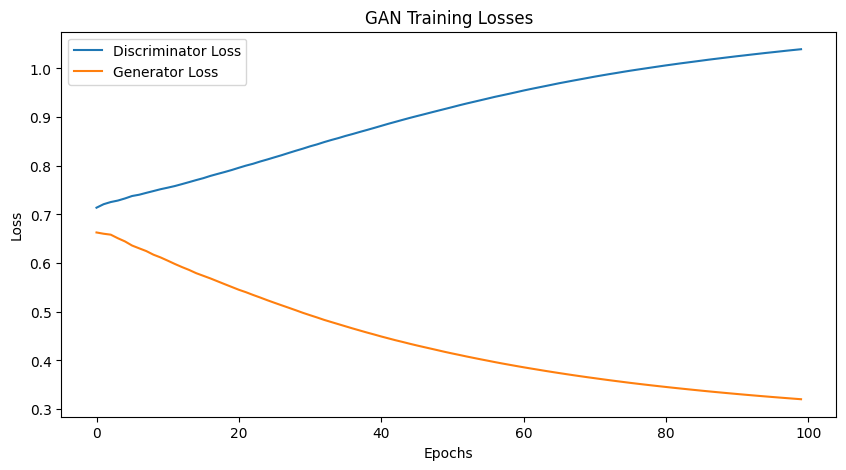

In [ ]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.show()

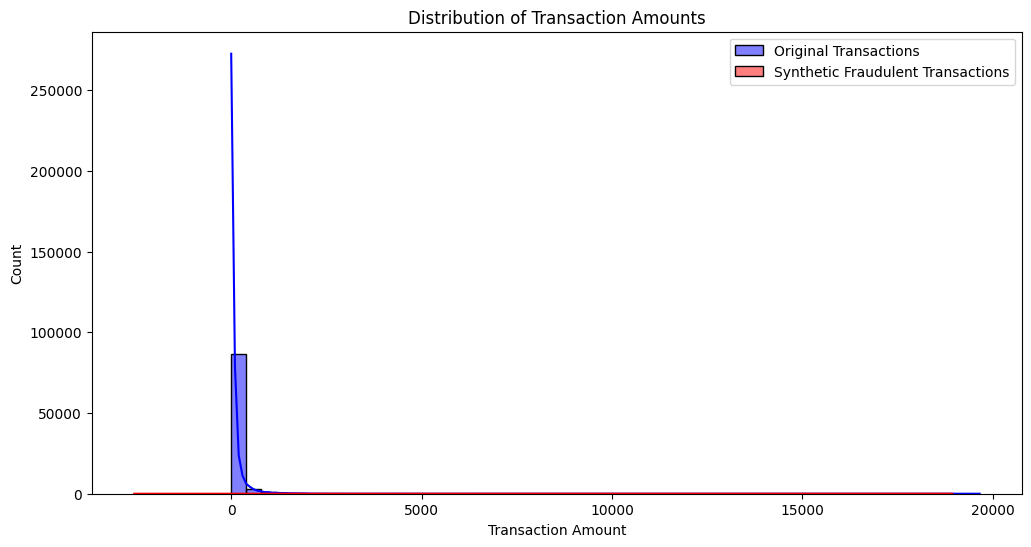

In [ ]:
# Display Data Distributions
plt.figure(figsize=(12, 6))
sns.histplot(data["Amount"], bins=50, kde=True, color='blue', label='Original Transactions')
sns.histplot(synthetic_fraud_df["Amount"], bins=50, kde=True, color='red', label='Synthetic Fraudulent Transactions')
plt.legend()
plt.xlabel("Transaction Amount")
plt.title("Distribution of Transaction Amounts")
plt.show()


In [ ]:
# Evaluate Model Performance
real_labels = np.ones(len(fraud_data))
gen_labels = np.zeros(len(synthetic_fraud))

y_true = np.concatenate((real_labels, gen_labels))
y_pred = discriminator.predict(np.vstack((fraud_data, synthetic_fraud)))
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model Accuracy: 0.7918
Precision: 0.8987
Recall: 0.3365
F1 Score: 0.4897


In [ ]:
# Function to Classify New Transactions
def classify_transactions(new_data_path):
    new_data = pd.read_csv(new_data_path)
    new_features = new_data.drop(columns=['Class'], errors='ignore')
    new_features = scaler.transform(new_features)
    predictions = fraud_classifier.predict(new_features)
    new_data['Predicted_Class'] = (predictions > 0.5).astype(int)
    print(new_data[['Predicted_Class']].value_counts())
    return new_data

In [ ]:
classified_data = classify_transactions('/content/creditcard.csv')


NameError: name 'fraud_classifier' is not defined